# DWPP Simulation Result Analysis

## Import

In [325]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path
import os
from collections import defaultdict

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

controller_list = ["PP", "APP", "RPP", "DWPP"]
color_dict = {"PP": "blue", "APP": "green", "RPP": "orange", "DWPP": "red"}
path_dict = defaultdict(lambda: defaultdict(list))



## Make reference path

In [326]:
def make_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    paths = []
    # 生成するカーブの角度パターン
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4]
    l_segment = 3.0  # 直線区間の長さパラメータ

    for theta in theta_list:
        # 1. 直進 (0 -> 1m)
        x1 = np.linspace(0, 1, 100)
        y1 = np.zeros_like(x1)
        
        # 2. 斜め直線 (角度thetaで長さl)
        # Note: 実際には直線補間だが、ここでは簡易的に生成
        x2 = np.linspace(1.0, 1.0 + l_segment * math.cos(theta), 300)
        y2 = np.linspace(0.0, l_segment * math.sin(theta), 300)
        
        # 3. 終端直進 (さらに3m進む)
        x3 = np.linspace(
            1.0 + l_segment * math.cos(theta), 
            4.0 + l_segment * math.cos(theta), 300)
        y3 = np.ones_like(x3) * l_segment * math.sin(theta)

        # 結合
        xs = np.concatenate([x1, x2, x3])
        ys = np.concatenate([y1, y2, y3])
        
        path = np.c_[xs, ys]
        
        paths.append(path)
        

    # 展開して返す
    return (paths[0], paths[1], paths[2])

PathA, PathB, PathC = make_path()
reference_path = {
    "PathA": PathA,
    "PathB": PathB,
    "PathC": PathC
}


## Velocity violation ratio

In [327]:
def calc_violation_rate(violation_flags) -> float:
    violation_count = np.sum(violation_flags)
    total_count = len(violation_flags)
    violation_rate = violation_count / total_count
    return violation_rate

## Cross-track error RMSE

In [328]:
from scipy.spatial.distance import cdist

def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse


## Divide df

In [329]:
def divide_df_to_segments(df: pd.DataFrame, t_threshold: float) -> list:
    """
    Divide the DataFrame into segments based on time gaps exceeding the threshold.
    
    Args:
        df (pd.DataFrame): Input DataFrame with a 'timestamp' column.
        t_threshold (float): Time gap threshold to identify segments.
        
    Returns:
        list: List of DataFrame segments.
    """
    t = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
    
    # diffをとる
    t_diff = np.diff(t, prepend=t[0])
    print(t_diff)
    
    # diffが閾値以上のindexでcsvを分割する
    split_indices = np.where(t_diff >= t_threshold)[0]
    
    # split_indices から各区間を作成
    split_points = np.r_[0, split_indices, len(df)]
    segments = []
    for start, end in zip(split_points[:-1], split_points[1:]):
        segment = df.iloc[start:end].copy()
        if not segment.empty:
            segments.append(segment)
    
    print(f"Found {len(segments)} segments (threshold={t_threshold})")
    for i, segment in enumerate(segments):
        span = segment["sec"].iloc[-1] - segment["sec"].iloc[0]
        print(f" segment {i}: rows={len(segment)}, span={span:.3f}s")
    
    return segments



## Plot Velocity profile

In [330]:
def plot_velocity_profile(t, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir):
    # Create subplots for translational and rotational velocities (horizontal layout)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # Plot translational velocity
    ax1.plot(t, v_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
    ax1.plot(t, v_real, '-', color='blue', label='Actual', linewidth=3)
    # Add velocity limit line
    ax1.axhline(y=0.26, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')

    # Plot rotational velocity
    ax2.plot(t, w_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
    # ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
    ax2.plot(t, w_real, '-', color='blue', label='Actual', linewidth=3)
    # Add velocity limit lines
    ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')
    ax2.axhline(y=-0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Min Velocity')

    # Set labels and legends
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Linear Velocity [m/s]')
    ax1.set_yticks([0, 0.10, 0.20])
    ax1.grid(True, alpha=0.3)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Angular Velocity [rad/s]')
    ax2.set_ylim(-0.7, 0.7)
    ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax2.grid(True, alpha=0.3)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    filename = data_dir / path_name / f"{path_name}_{controller_name}_velocity_sim.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    

## Plot Dynamic Window

In [331]:
def plot_dynamic_window(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs, path_name, controller_name):
    base_dir = '/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow'
    os.makedirs(f'{base_dir}/{path_name}/{controller_name}', exist_ok=True)
    
    for idx, (curvature, v, w, next_v, next_w, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg) \
        in enumerate(zip(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs)):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        
        # Dynamic Windowの範囲を四角形でプロット
        vertexes = [
            (dw_min_v, dw_min_w),
            (dw_min_v, dw_max_w),
            (dw_max_v, dw_max_w),
            (dw_max_v, dw_min_w)
        ]
        rectangle = patches.Polygon(vertexes, closed=True, fill=False, color='black', alpha=1.0, label='Dynamic Window')
        ax.add_patch(rectangle)
        
        # omega = curvature * v の直線をプロット
        v_list = np.linspace(-0.1, 0.6, 100)
        omega_line = curvature * v_list
        ax.plot(v_list, omega_line, 'g--', label='ω = k * v')
        
        # 現在の速度点
        ax.scatter(v, w, s=12, color='blue', label='Current Velocity')
        # 速度指令値の速度点
        ax.scatter(next_v, next_w, s=12, color='red', label='Command Velocity')
        # 制御後の速度点
        ax.scatter(actual_v, actual_w, s=12, color='magenta', label='Actual Velocity')
        
        # v_regの描画
        ax.axvline(x=v_reg, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Regulated Velocity')
        
        ax.set_xlabel('Linear Velocity [m/s]')
        ax.set_ylabel('Angular Velocity [rad/s]')
        ax.set_xlim(-0.1, 0.6)
        ax.set_ylim(-1.2, 1.2)
        ax.grid(True, alpha=0.3)
        # ax.set_aspect('equal')
        # plt.legend()
        plt.savefig(f'{base_dir}/{path_name}/{controller_name}/{idx}.png', dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close()
    

## Measure Traveling time

In [332]:
def measure_travel_time(timestamp):
    start_time = timestamp[0]
    end_time = timestamp[-1]
    travel_time = end_time - start_time
    return travel_time

## Plot Path

In [333]:
def plot_path(path_dict, path_name, base_dir):
    fig = plt.figure(figsize=(6.5,6.5))
    ax = fig.add_subplot(1, 1, 1)
    for controller_name in controller_list:
        # print(path_dict[path_name][controller_name])
        data = path_dict[path_name][controller_name][0]
        
        x = data.T[0]
        y = data.T[1]
        # Plot robot trajectory (rotate: X->Y, Y->-X for X-up, Y-left coordinate system)
        ax.plot(y, [-x for x in x], color=color_dict[controller_name], label=controller_name, linewidth=4.5)

    robot_path = reference_path[path_name]
    ref_x = [point[0] for point in robot_path]
    ref_y = [point[1] for point in robot_path]
    ax.plot(ref_y, [-x for x in ref_x], 'k--', label='Reference Path', linewidth=3, alpha=0.7)
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')

    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()
    plt.legend()
    
    filepath = base_dir / path_name / f'{path_name}_comparison_sim.png'

    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

## Analysis

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp_simulation/PathB_sim.csv:
[0.         0.03307724 0.03356528 ... 0.03339934 0.03341055 0.03500342]
Found 4 segments (threshold=1.0)
 segment 0: rows=1055, span=35.000s
 segment 1: rows=954, span=32.000s
 segment 2: rows=959, span=32.000s
 segment 3: rows=1018, span=34.000s
['PathB', 'sim']
 Velocity violation rate: 38.96%
 RMSE to PathB of PP: 0.1865 m
 Travel time of PP: 35.13 s


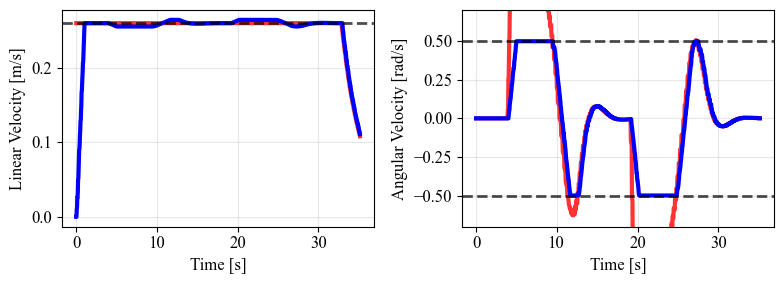

 Velocity violation rate: 21.80%
 RMSE to PathB of APP: 0.0806 m
 Travel time of APP: 31.77 s


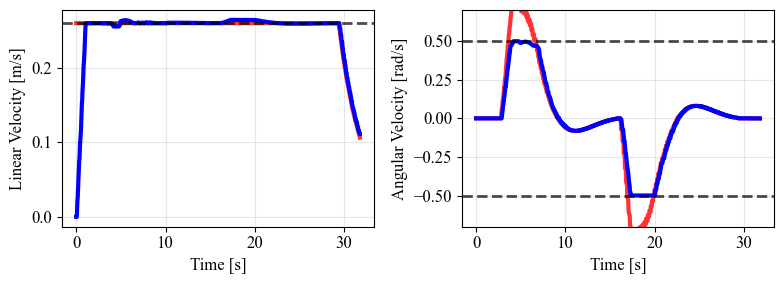

 Velocity violation rate: 21.90%
 RMSE to PathB of RPP: 0.0766 m
 Travel time of RPP: 31.93 s


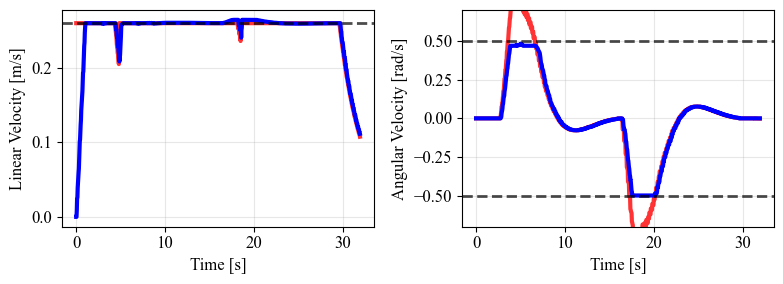

 Velocity violation rate: 0.00%
 RMSE to PathB of DWPP: 0.0374 m
 Travel time of DWPP: 33.90 s


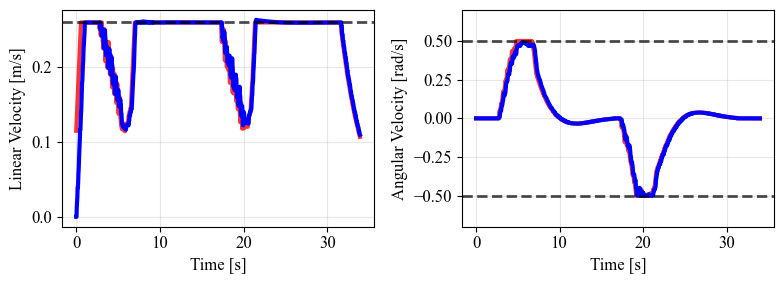

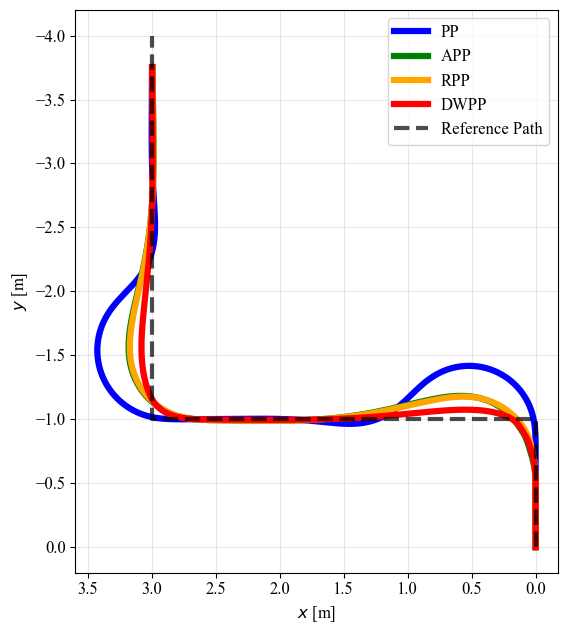

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp_simulation/PathA_sim.csv:
[0.         0.03219604 0.03335524 ... 0.03325963 0.03328848 0.03336215]
Found 4 segments (threshold=1.0)
 segment 0: rows=971, span=32.000s
 segment 1: rows=957, span=32.000s
 segment 2: rows=962, span=33.000s
 segment 3: rows=964, span=32.000s
['PathA', 'sim']
 Velocity violation rate: 18.95%
 RMSE to PathA of PP: 0.0260 m
 Travel time of PP: 32.33 s


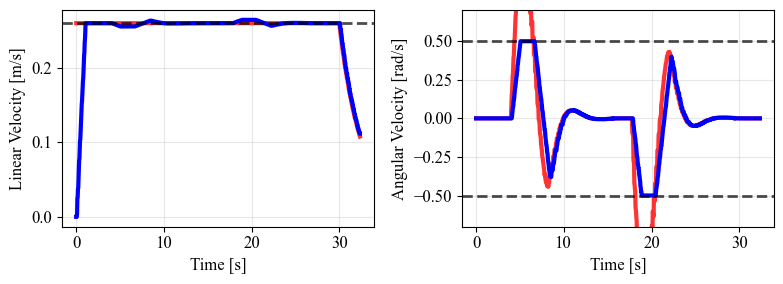

 Velocity violation rate: 0.63%
 RMSE to PathA of APP: 0.0228 m
 Travel time of APP: 31.87 s


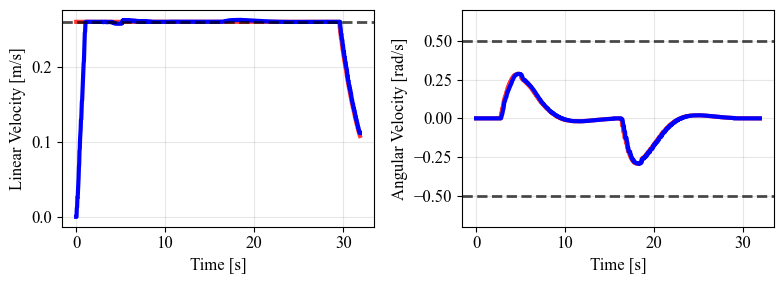

 Velocity violation rate: 0.62%
 RMSE to PathA of RPP: 0.0219 m
 Travel time of RPP: 32.03 s


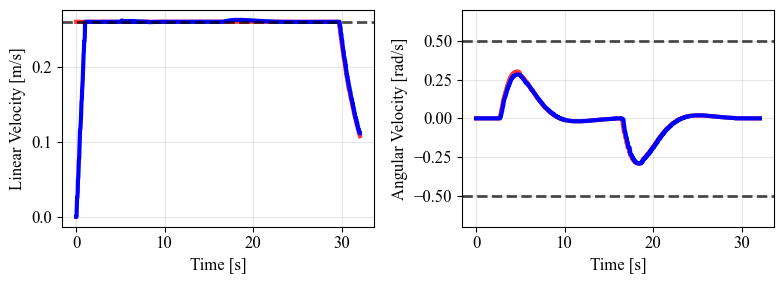

 Velocity violation rate: 0.00%
 RMSE to PathA of DWPP: 0.0226 m
 Travel time of DWPP: 32.10 s


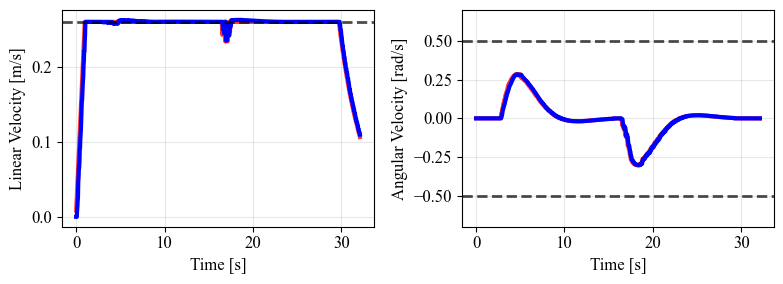

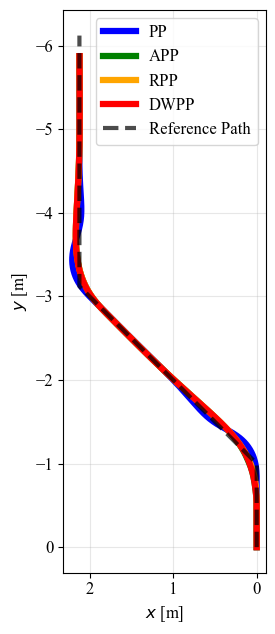

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp_simulation/PathC_sim.csv:
[0.         0.03359246 0.03284717 ... 0.0332799  0.03339076 0.03346753]
Found 4 segments (threshold=1.0)
 segment 0: rows=1256, span=42.000s
 segment 1: rows=1088, span=36.000s
 segment 2: rows=1073, span=36.000s
 segment 3: rows=1176, span=40.000s
['PathC', 'sim']
 Velocity violation rate: 42.36%
 RMSE to PathC of PP: 0.4075 m
 Travel time of PP: 41.83 s


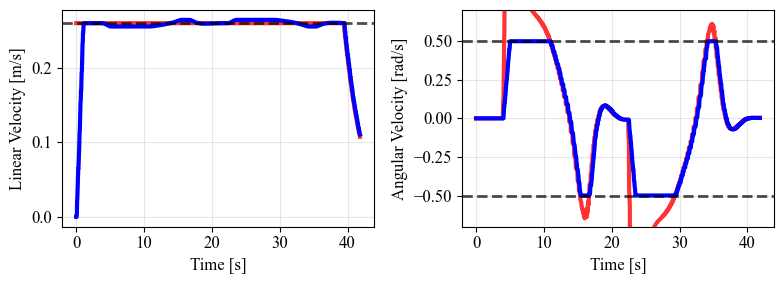

 Velocity violation rate: 31.16%
 RMSE to PathC of APP: 0.3217 m
 Travel time of APP: 36.23 s


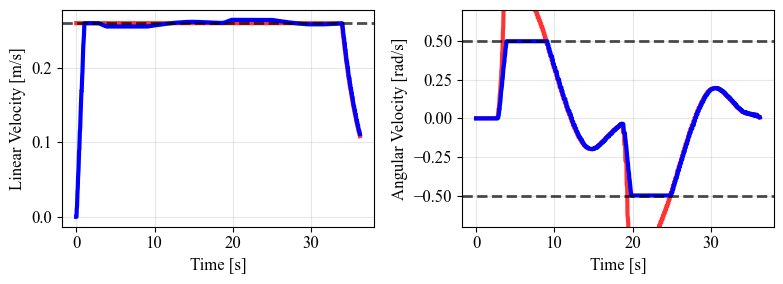

 Velocity violation rate: 35.04%
 RMSE to PathC of RPP: 0.1692 m
 Travel time of RPP: 35.73 s


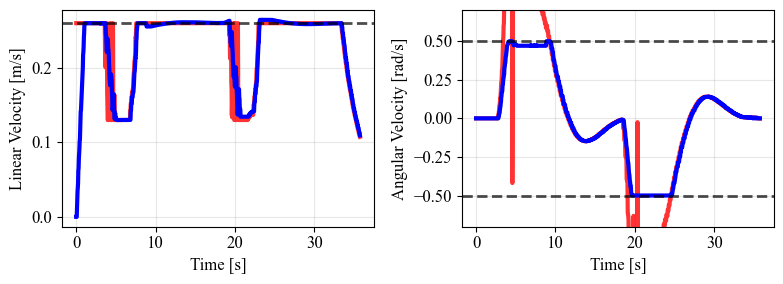

 Velocity violation rate: 0.00%
 RMSE to PathC of DWPP: 0.0671 m
 Travel time of DWPP: 39.17 s


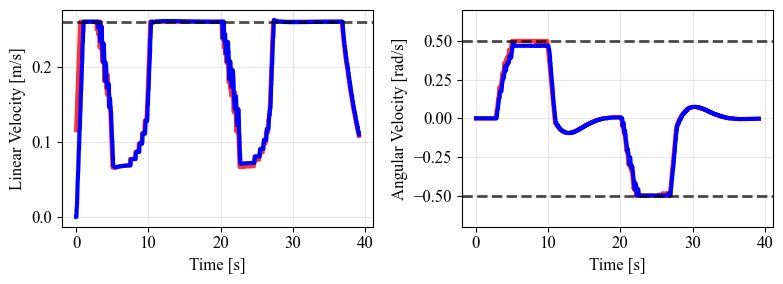

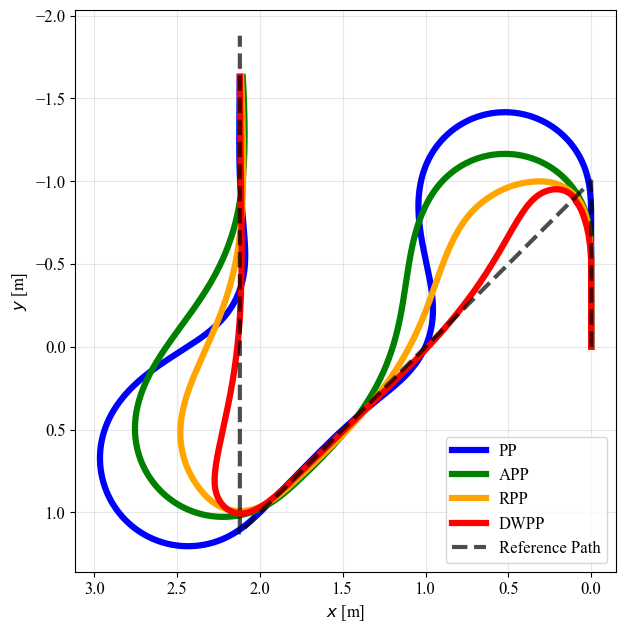

In [334]:
data_dir = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp_simulation")
csv_paths = list(data_dir.glob("*.csv"))
os.makedirs(data_dir / 'PathA', exist_ok=True)
os.makedirs(data_dir / 'PathB', exist_ok=True)
os.makedirs(data_dir / 'PathC', exist_ok=True)

for csv_path in csv_paths:
    df = pd.read_csv(csv_path)
    print(f"Data from {csv_path}:")
    
    # Divide into segments based on time gaps
    segments = divide_df_to_segments(df, t_threshold=1.0)
    
    # Extract path name and controller name from file name
    file_stem = csv_path.stem  # e.g., "PathA_DWPP_test1"
    parts = file_stem.split('_')
    
    print(parts)
    path_name = parts[0]  # e.g., "PathA"
    controller_name = parts[1]  # e.g., "DWPP"
    
    for segment, controller_name in zip(segments, controller_list):
        # Extract relevant data
        timestamp = segment["sec"].to_numpy() + segment["nsec"].to_numpy() * 1e-9
        timestamp -= timestamp[0]  # Normalize to start from zero
        curvature = segment["curvature"].to_numpy()
        v_now = segment["v_now"].to_numpy()
        w_now = segment["w_now"].to_numpy()
        v_cmd = segment["v_cmd"].to_numpy()
        w_cmd = segment["w_cmd"].to_numpy()
        actual_v = segment["v_nav"].to_numpy()
        actual_w = segment["w_nav"].to_numpy()
        v_real = segment["v_real"].to_numpy()
        w_real = segment["w_real"].to_numpy()
        dw_max_v = segment["dw_v_max"].to_numpy()
        dw_max_w = segment["dw_w_max"].to_numpy()
        dw_min_v = segment["dw_v_min"].to_numpy()
        dw_min_w = segment["dw_w_min"].to_numpy()
        v_reg = segment["v_reg"].to_numpy()
        
        x = segment["x"].to_numpy()
        y = segment["y"].to_numpy()
        velocity_violation = segment["velocity_violation"].to_numpy()
        
        # calc velocity violation ratio
        violation_rate = calc_violation_rate(velocity_violation)
        print(f" Velocity violation rate: {violation_rate*100:.2f}%")
        
        # calc RMSE
        path = reference_path[path_name]
        robot_path = np.vstack((x, y)).T
        rmse = calc_rmse(robot_path, path)
        print(f" RMSE to {path_name} of {controller_name}: {rmse:.4f} m")
        path_dict[path_name][controller_name].append(robot_path)
        
        # calc travel time
        travel_time = measure_travel_time(timestamp)
        print(f" Travel time of {controller_name}: {travel_time:.2f} s")
        
        # plot velocity profile
        plot_velocity_profile(timestamp, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir)
        
        # plot dynamic window
        # plot_dynamic_window(curvature, v_now, w_now, v_cmd, w_cmd, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg, path_name, controller_name)

    # Plot Path
    plot_path(path_dict, path_name, data_dir)
